In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from roll_window_cross_val import *
import lightgbm as lgb
from scipy.stats import norm
import shap

In [2]:
data = pd.read_csv('data.csv', low_memory=False)
metadata = pd.read_csv('metadata.csv', low_memory=False)

In [3]:
data.head(2)

,time_series_code,date,value
0,BOPGS_BAL_US_adj,1992-01-01,-2026
1,BOPGS_EXP_US_adj,1992-01-01,50251


In [4]:
metadata.head(2)

,cat_code,cat_desc,category_level,dt_code,dt_desc,dt_unit,et_code,et_desc,et_unit,geo_code,geo_desc,is_adj,report,detail_code,time_series_code
0,BOPGS,Balance of Payment Goods and Services,0,BAL,Balance,Millions of Dollars,NaN,NaN,NaN,US,United States,1,U.S. International Trade in Goods and Services,BAL,BOPGS_BAL_US_adj
1,BOPGS,Balance of Payment Goods and Services,0,EXP,Exports,Millions of Dollars,NaN,NaN,NaN,US,United States,1,U.S. International Trade in Goods and Services,EXP,BOPGS_EXP_US_adj


In [5]:
metadata['report'].value_counts()

Quarterly Financial Report                            4784
Quarterly Services Survey                             1460
Manufacturers' Shipments, Inventories, and Orders     1454
Quarterly Summary of State & Local Taxes              1392
Monthly Retail Trade and Food Services                 584
Monthly Wholesale Trade: Sales and Inventories         440
Construction Spending                                  288
New Residential Construction                           176
Advance Monthly Sales for Retail and Food Services     152
Manufactured Housing Survey (1980-2013)                102
Housing Vacancies and Homeownership                     89
Manufacturing and Trade Inventories and Sales           64
New Home Sales                                          58
Quarterly Survey of Public Pensions                     29
Manufactured Housing Survey (Current)                   28
U.S. International Trade in Goods and Services           6
Name: report, dtype: int64

In [6]:
df = pd.merge(data, metadata, how = 'left', on = 'time_series_code')

In [7]:
df_report = df[df['report'] == 'Manufacturing and Trade Inventories and Sales']

In [8]:
df_report['cat_desc'].value_counts()

Merchant Wholesalers    5046
Retailers               5046
Total Business          3864
Manufacturers           3076
Name: cat_desc, dtype: int64

In [9]:
df_mfg = df_report[df_report['cat_desc'] == 'Manufacturers']

In [10]:
df_mfg['value'] = df_mfg['value'].astype(float)

In [11]:
df_mfg['date'] = pd.to_datetime(df_mfg['date'])

In [12]:
def plot_ts(x, df, i, name):
    sns.set(style='whitegrid', rc={
            'lines.linewidth': 2.5, 'figure.figsize': (16, 8)})
    sns.set_palette('viridis_r', n_colors=3)
    sns.lineplot(x=df[i], y=df[x])
    plt.title(name)

In [13]:
df_mfg_sales = df_mfg[df_mfg['time_series_code'] == 'MNFCTR_SM_US']

In [14]:
df_mfg_sales['value'].describe()

count       308.000000
mean     376485.847403
std       78963.031672
min      209438.000000
25%      316447.500000
50%      362488.500000
75%      451726.500000
max      516793.000000
Name: value, dtype: float64

Среднее значение около 380000, при этом стандартное отклонение всего около 80000 (около 20% от среднего), то есть у ряда достаточно низкий разброс.

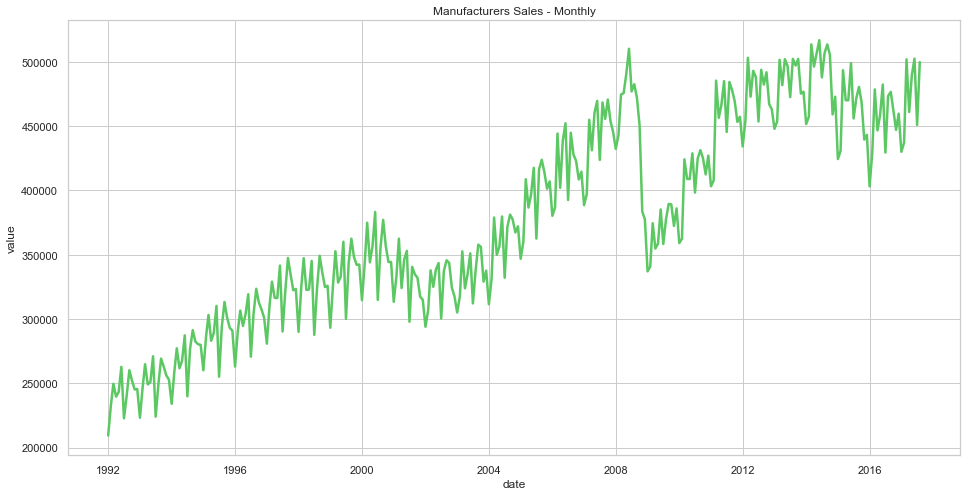

In [15]:
plot_ts('value', df_mfg_sales, 'date', 'Manufacturers Sales - Monthly')
plt.show()

На графике видим растущий тренд и один серьезный разрыв (в 2008-2009, скорее всего, связанный с глобальным кризисом). Попробуем на основе первый нескольких лет выделить мультипликативный тренд из ряда, и моделировать уже очищенные значения, так как не все модели справляются с экстраполяцией значений.

In [16]:
# посчитаем прирост год к году

df_mfg_sales['year_to_year'] = df_mfg_sales['value'] / df_mfg_sales['value'].shift(12)

In [17]:
# средний прирост год к году по первым 12 годам составляет 3%

df_mfg_sales['year_to_year'][:12*12].describe()

count    132.000000
mean       1.030863
std        0.043007
min        0.887800
25%        1.008521
50%        1.037907
75%        1.061022
max        1.112402
Name: year_to_year, dtype: float64

In [18]:
df_mfg_sales['value_no_trend'] = df_mfg_sales['value'].copy()
for i in range(1, len(df_mfg_sales) + 1):
    df_mfg_sales['value_no_trend'].iloc[i-1] = df_mfg_sales['value'].iloc[i-1] / ((df_mfg_sales['year_to_year'][:12*12].mean() ** (1/12)) ** i)
df_mfg_sales['value_predicted_by_trend'] = df_mfg_sales['value'].shift(12) * df_mfg_sales['year_to_year'][:12*12].mean()

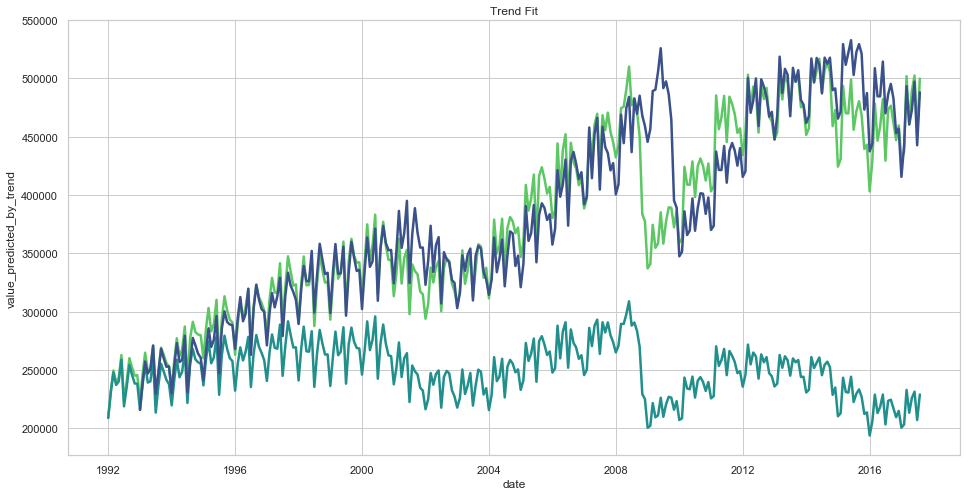

In [19]:
plot_ts('value', df_mfg_sales, 'date', '')
plot_ts('value_no_trend', df_mfg_sales, 'date', '')
plot_ts('value_predicted_by_trend', df_mfg_sales, 'date', 'Trend Fit')
plt.show()

Видим, что мультипликативный тренд, рассчитаный из показателя год к году уже сам по себе неплохо попадает, если не считать выброс.

In [20]:
df_mfg_sales['Year'] = df_mfg_sales["date"].dt.year
df_mfg_sales['Month'] = df_mfg_sales["date"].dt.month
df_mfg_sales['Quarter'] = df_mfg_sales["date"].dt.quarter
df_mfg_sales['Days_In_Month'] = df_mfg_sales["date"].dt.daysinmonth
df_mfg_sales['t'] = (df_mfg_sales["date"] - df_mfg_sales["date"].min()) / np.timedelta64(1, 'D')

In [21]:
df_mfg_sales['num_quart'] = df_mfg_sales['Year'].astype(str) + '_' + df_mfg_sales['Quarter'].astype(str)

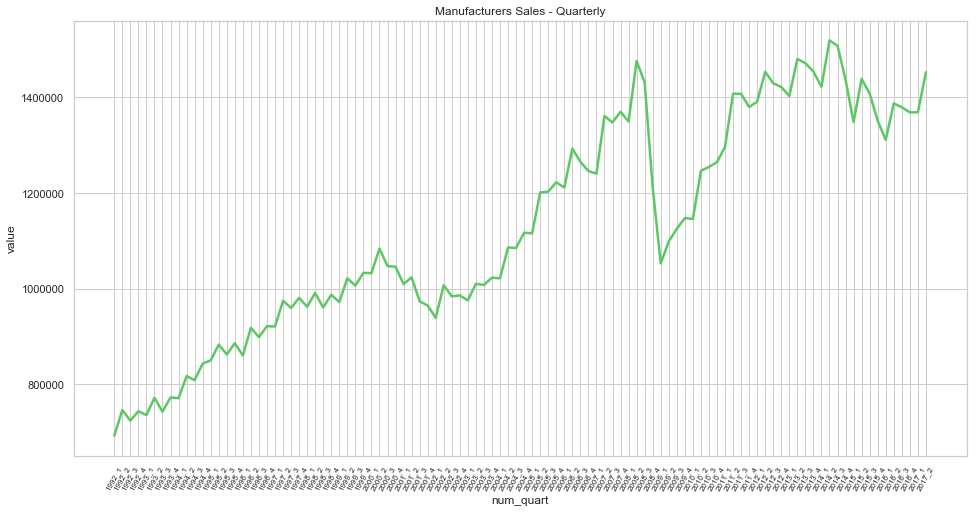

In [34]:
# Построим график с агрегацией поквартально

plot_ts('value', df_mfg_sales.groupby('num_quart').sum().reset_index()[:-1], 'num_quart', 'Manufacturers Sales - Quarterly')
plt.xticks(fontsize = 8, rotation = 60)
plt.show()

Посчитаем признаки - лаги и приросты, уже для очищенного от тренда ряда, минимальный лаг - 3 месяца, равен горизонту прогнозирования.

In [23]:
number_lags = 12
for lag in range(3, number_lags + 1):
    df_mfg_sales['lag_' + str(lag)] = df_mfg_sales['value'].shift(lag)
    df_mfg_sales['diff_' + str(lag)] = df_mfg_sales['value'].shift(lag) - df_mfg_sales['value'].shift(lag + 1)

In [24]:
df_mfg_sales[13:].head()

,time_series_code,date,value,cat_code,cat_desc,category_level,dt_code,dt_desc,dt_unit,et_code,...,lag_8,diff_8,lag_9,diff_9,lag_10,diff_10,lag_11,diff_11,lag_12,diff_12
742621,MNFCTR_SM_US,1993-02-01,246941.0,MNFCTR,Manufacturers,0,SM,Sales - Monthly,Millions of Dollars,NaN,...,262854.0,19623.0,243231.0,3565.0,239666.0,-10007.0,249673.0,16994.0,232679.0,23241.0
742661,MNFCTR_SM_US,1993-03-01,264886.0,MNFCTR,Manufacturers,0,SM,Sales - Monthly,Millions of Dollars,NaN,...,222832.0,-40022.0,262854.0,19623.0,243231.0,3565.0,239666.0,-10007.0,249673.0,16994.0
742701,MNFCTR_SM_US,1993-04-01,249181.0,MNFCTR,Manufacturers,0,SM,Sales - Monthly,Millions of Dollars,NaN,...,240299.0,17467.0,222832.0,-40022.0,262854.0,19623.0,243231.0,3565.0,239666.0,-10007.0
742741,MNFCTR_SM_US,1993-05-01,250870.0,MNFCTR,Manufacturers,0,SM,Sales - Monthly,Millions of Dollars,NaN,...,260216.0,19917.0,240299.0,17467.0,222832.0,-40022.0,262854.0,19623.0,243231.0,3565.0
742781,MNFCTR_SM_US,1993-06-01,271047.0,MNFCTR,Manufacturers,0,SM,Sales - Monthly,Millions of Dollars,NaN,...,252272.0,-7944.0,260216.0,19917.0,240299.0,17467.0,222832.0,-40022.0,262854.0,19623.0


In [25]:
df_mfg_sales.columns

Index(['time_series_code', 'date', 'value', 'cat_code', 'cat_desc',
       'category_level', 'dt_code', 'dt_desc', 'dt_unit', 'et_code', 'et_desc',
       'et_unit', 'geo_code', 'geo_desc', 'is_adj', 'report', 'detail_code',
       'year_to_year', 'value_no_trend', 'value_predicted_by_trend', 'Year',
       'Month', 'Quarter', 'Days_In_Month', 't', 'num_quart', 'lag_3',
       'diff_3', 'lag_4', 'diff_4', 'lag_5', 'diff_5', 'lag_6', 'diff_6',
       'lag_7', 'diff_7', 'lag_8', 'diff_8', 'lag_9', 'diff_9', 'lag_10',
       'diff_10', 'lag_11', 'diff_11', 'lag_12', 'diff_12'],
      dtype='object')

In [26]:
# Используемые признаки
lst_f = ['Year', 'Month', 'Quarter', 'Days_In_Month', 't', 'lag_3', 'lag_4', 'lag_5',
         'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12',
         'diff_3', 'diff_4', 'diff_5', 'diff_6', 'diff_7', 'diff_8', 'diff_9',
         'diff_10', 'diff_11', 'diff_12']

Была выбрана модель lightgbm (во-первых, возможна экстраполяция значений, во-вторых, деревья более устойчивы к выбросам). В качестве метрики качества для подбора гиперпараметров (используется hyperopt) была выбрана SMAPE. Эта метрика, во-первых, очень понятна (отклонение в процентах), но в отличии от MAPE симметрична и не происходит занижение значений, как это обычно бывает при работе с MAPE, во-вторых, более устойчива к выбросам/разрывам (которые здесь есть), чем например MSE (не хочется переобучаться под кризис 2008-2009 года).

Обязательно валидируемся на выбросе (разрыве) тоже, чтобы понять, насколько модель плохо там работает.
Кросс-валидация методом скользящего окна: обучаемся на 148 точках (чтобы последние 3 точки тоже захватить), предсказываем на 3 вперед, записываем точность, сдвигаемся на 3 точки вперед и повторяем и так до конца ряда.

In [27]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'learning_rate': params['learning_rate'],
        'min_child_samples': int(params['min_child_samples']),
        'n_estimators': int(params['n_estimators']),
        'feature_fraction': params['feature_fraction'],
        'bagging_fraction': params['bagging_fraction'],
        'lambda_l2': params['lambda_l2'],
        'lambda_l1': params['lambda_l1']
    }
    regr = lgb.LGBMRegressor(
        reg_sqrt=True,
        num_threads=8,
        objective='mse',
        bagging_freq=5,
        boost_from_average=True,
        seed=42,
        subsample_freq=5,
        **params
    )

    metrics = rolling_window_score(
        regr, df_mfg_sales[13:], 'value_no_trend', lst_f, 'date', 148, 3, 3)
    score = np.mean(metrics)
    print([np.min(metrics), np.mean(metrics), np.max(metrics)], params)
    return score


space = {
    'learning_rate': hp.quniform('learning_rate', 0.002, 0.9, 0.002),
    'min_child_samples': hp.quniform('min_child_samples', 1, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 500, 1),
    'num_leaves': hp.quniform('num_leaves', 3, 32, 1),
    'feature_fraction': hp.quniform('feature_fraction', 0.1, 1.0, 0.05),
    'bagging_fraction': hp.quniform('bagging_fraction', 0.1, 1.0, 0.05),
    'lambda_l2': hp.quniform('lambda_l2', 0., 100, 1),
    'lambda_l1': hp.quniform('lambda_l1', 0., 2000, 1)
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=500)

[2.565025609238758, 8.474752551501773, 21.782681261546397]                     
{'num_leaves': 20, 'learning_rate': 0.742, 'min_child_samples': 2, 'n_estimators': 171, 'feature_fraction': 0.25, 'bagging_fraction': 0.9500000000000001, 'lambda_l2': 13.0, 'lambda_l1': 1381.0}
[2.565025609238758, 8.474752551501773, 21.782681261546397]                     
{'num_leaves': 25, 'learning_rate': 0.538, 'min_child_samples': 7, 'n_estimators': 52, 'feature_fraction': 0.45, 'bagging_fraction': 0.2, 'lambda_l2': 80.0, 'lambda_l1': 587.0}
[2.565025609238758, 8.474752551501773, 21.782681261546397]                     
{'num_leaves': 29, 'learning_rate': 0.268, 'min_child_samples': 3, 'n_estimators': 497, 'feature_fraction': 0.35000000000000003, 'bagging_fraction': 0.75, 'lambda_l2': 50.0, 'lambda_l1': 1878.0}
[2.565025609238758, 8.484342488133933, 21.782681261546397]                     
{'num_leaves': 25, 'learning_rate': 0.23600000000000002, 'min_child_samples': 7, 'n_estimators': 229, 'feature_fra

{'num_leaves': 23, 'learning_rate': 0.008, 'min_child_samples': 2, 'n_estimators': 351, 'feature_fraction': 0.9500000000000001, 'bagging_fraction': 0.8500000000000001, 'lambda_l2': 17.0, 'lambda_l1': 154.0}
[2.4517731491276424, 8.277481251926428, 21.782681261546397]                    
{'num_leaves': 30, 'learning_rate': 0.5760000000000001, 'min_child_samples': 7, 'n_estimators': 406, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 0.9500000000000001, 'lambda_l2': 28.0, 'lambda_l1': 717.0}
[2.565025609238758, 8.44328127696111, 21.782681261546397]                      
{'num_leaves': 25, 'learning_rate': 0.682, 'min_child_samples': 4, 'n_estimators': 213, 'feature_fraction': 0.4, 'bagging_fraction': 0.8, 'lambda_l2': 11.0, 'lambda_l1': 854.0}
[2.565025609238758, 8.474752551501773, 21.782681261546397]                     
{'num_leaves': 24, 'learning_rate': 0.484, 'min_child_samples': 3, 'n_estimators': 451, 'feature_fraction': 0.9, 'bagging_fraction': 0.65, 'lambda_l2': 29.0

{'num_leaves': 14, 'learning_rate': 0.704, 'min_child_samples': 1, 'n_estimators': 72, 'feature_fraction': 0.5, 'bagging_fraction': 0.8500000000000001, 'lambda_l2': 73.0, 'lambda_l1': 634.0}
[1.33510103264823, 7.2139431947910575, 23.244098682480164]                     
{'num_leaves': 12, 'learning_rate': 0.888, 'min_child_samples': 2, 'n_estimators': 185, 'feature_fraction': 0.9500000000000001, 'bagging_fraction': 0.8, 'lambda_l2': 10.0, 'lambda_l1': 308.0}
[1.5599362877322596, 7.584665335897172, 23.21253329155617]                     
{'num_leaves': 15, 'learning_rate': 0.81, 'min_child_samples': 3, 'n_estimators': 212, 'feature_fraction': 0.9, 'bagging_fraction': 0.9500000000000001, 'lambda_l2': 83.0, 'lambda_l1': 427.0}
[0.7153006759845985, 5.78147567542062, 23.82303767480672]                      
{'num_leaves': 18, 'learning_rate': 0.528, 'min_child_samples': 1, 'n_estimators': 113, 'feature_fraction': 0.8500000000000001, 'bagging_fraction': 0.7000000000000001, 'lambda_l2': 49.0,

{'num_leaves': 15, 'learning_rate': 0.14200000000000002, 'min_child_samples': 3, 'n_estimators': 328, 'feature_fraction': 0.9, 'bagging_fraction': 0.15000000000000002, 'lambda_l2': 43.0, 'lambda_l1': 550.0}
[2.565025609238758, 8.460122973593482, 21.782681261546397]                     
{'num_leaves': 10, 'learning_rate': 0.224, 'min_child_samples': 1, 'n_estimators': 298, 'feature_fraction': 0.8500000000000001, 'bagging_fraction': 1.0, 'lambda_l2': 63.0, 'lambda_l1': 1086.0}
[1.5222664261014596, 7.4510925691544525, 22.922532041274437]                   
{'num_leaves': 31, 'learning_rate': 0.736, 'min_child_samples': 4, 'n_estimators': 119, 'feature_fraction': 0.9500000000000001, 'bagging_fraction': 0.75, 'lambda_l2': 51.0, 'lambda_l1': 328.0}
[1.8674261350952626, 7.860956379805196, 23.248364086118023]                    
{'num_leaves': 26, 'learning_rate': 0.622, 'min_child_samples': 7, 'n_estimators': 209, 'feature_fraction': 0.30000000000000004, 'bagging_fraction': 0.7000000000000001

{'num_leaves': 18, 'learning_rate': 0.754, 'min_child_samples': 3, 'n_estimators': 385, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 1.0, 'lambda_l2': 19.0, 'lambda_l1': 873.0}
[2.565025609238758, 8.474752551501773, 21.782681261546397]                     
{'num_leaves': 25, 'learning_rate': 0.612, 'min_child_samples': 1, 'n_estimators': 335, 'feature_fraction': 1.0, 'bagging_fraction': 0.45, 'lambda_l2': 73.0, 'lambda_l1': 673.0}
[2.565025609238758, 8.474752551501773, 21.782681261546397]                     
{'num_leaves': 26, 'learning_rate': 0.6940000000000001, 'min_child_samples': 6, 'n_estimators': 312, 'feature_fraction': 0.65, 'bagging_fraction': 0.4, 'lambda_l2': 85.0, 'lambda_l1': 606.0}
[2.1770880042711793, 7.969231010085668, 22.81161417135735]                     
{'num_leaves': 24, 'learning_rate': 0.586, 'min_child_samples': 5, 'n_estimators': 346, 'feature_fraction': 0.75, 'bagging_fraction': 0.9, 'lambda_l2': 35.0, 'lambda_l1': 529.0}
[2.443618645110218, 8

{'num_leaves': 31, 'learning_rate': 0.262, 'min_child_samples': 5, 'n_estimators': 318, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.45, 'lambda_l2': 30.0, 'lambda_l1': 250.0}
[1.7567518315893724, 8.139984336566863, 23.36058289376467]                     
{'num_leaves': 24, 'learning_rate': 0.494, 'min_child_samples': 5, 'n_estimators': 395, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 0.5, 'lambda_l2': 22.0, 'lambda_l1': 338.0}
[0.9084024615355382, 5.030497753451934, 25.702878650290188]                    
{'num_leaves': 26, 'learning_rate': 0.16, 'min_child_samples': 3, 'n_estimators': 417, 'feature_fraction': 0.65, 'bagging_fraction': 0.55, 'lambda_l2': 36.0, 'lambda_l1': 35.0}
[1.36208011039037, 6.574289206870053, 24.221358543057914]                      
{'num_leaves': 30, 'learning_rate': 0.422, 'min_child_samples': 4, 'n_estimators': 374, 'feature_fraction': 0.55, 'bagging_fraction': 0.6000000000000001, 'lambda_l2': 15.0, 'lambda_l1': 152.0}
[1.13

{'num_leaves': 22, 'learning_rate': 0.75, 'min_child_samples': 2, 'n_estimators': 303, 'feature_fraction': 0.8, 'bagging_fraction': 0.9500000000000001, 'lambda_l2': 7.0, 'lambda_l1': 171.0}
[0.34227156618130766, 7.25005886914962, 22.628532707901034]                    
{'num_leaves': 20, 'learning_rate': 0.58, 'min_child_samples': 5, 'n_estimators': 376, 'feature_fraction': 0.75, 'bagging_fraction': 0.8500000000000001, 'lambda_l2': 45.0, 'lambda_l1': 340.0}
[2.565025609238758, 8.474752551501773, 21.782681261546397]                     
{'num_leaves': 13, 'learning_rate': 0.306, 'min_child_samples': 2, 'n_estimators': 199, 'feature_fraction': 0.8500000000000001, 'bagging_fraction': 0.75, 'lambda_l2': 68.0, 'lambda_l1': 1523.0}
[1.9477741725992002, 7.9857904953181285, 23.859644007448733]                   
{'num_leaves': 21, 'learning_rate': 0.512, 'min_child_samples': 9, 'n_estimators': 426, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 0.7000000000000001, 'lambda_l2': 18.

{'num_leaves': 15, 'learning_rate': 0.73, 'min_child_samples': 4, 'n_estimators': 453, 'feature_fraction': 0.55, 'bagging_fraction': 0.9, 'lambda_l2': 49.0, 'lambda_l1': 437.0}
[0.4441595498701912, 5.1673984568901945, 25.236539078051695]                   
{'num_leaves': 18, 'learning_rate': 0.048, 'min_child_samples': 3, 'n_estimators': 489, 'feature_fraction': 0.35000000000000003, 'bagging_fraction': 0.8, 'lambda_l2': 48.0, 'lambda_l1': 35.0}
[2.565025609238758, 8.474752551501773, 21.782681261546397]                     
{'num_leaves': 19, 'learning_rate': 0.762, 'min_child_samples': 4, 'n_estimators': 433, 'feature_fraction': 0.5, 'bagging_fraction': 0.8500000000000001, 'lambda_l2': 36.0, 'lambda_l1': 1971.0}
[1.4946170208176723, 6.274975990394246, 22.90411090838017]                     
{'num_leaves': 13, 'learning_rate': 0.722, 'min_child_samples': 3, 'n_estimators': 402, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0, 'lambda_l2': 60.0, 'lambda_l1': 190.0}
[2.109

{'num_leaves': 26, 'learning_rate': 0.114, 'min_child_samples': 1, 'n_estimators': 485, 'feature_fraction': 0.65, 'bagging_fraction': 0.9500000000000001, 'lambda_l2': 48.0, 'lambda_l1': 978.0}
[2.565025609238758, 8.474752551501773, 21.782681261546397]                     
{'num_leaves': 27, 'learning_rate': 0.742, 'min_child_samples': 2, 'n_estimators': 406, 'feature_fraction': 0.45, 'bagging_fraction': 0.7000000000000001, 'lambda_l2': 39.0, 'lambda_l1': 1245.0}
[0.5922844481711362, 4.426305294715558, 23.02670886182539]                     
{'num_leaves': 21, 'learning_rate': 0.77, 'min_child_samples': 4, 'n_estimators': 341, 'feature_fraction': 0.8500000000000001, 'bagging_fraction': 0.75, 'lambda_l2': 50.0, 'lambda_l1': 2.0}
[2.565025609238758, 8.474752551501773, 21.782681261546397]                     
{'num_leaves': 17, 'learning_rate': 0.64, 'min_child_samples': 1, 'n_estimators': 499, 'feature_fraction': 0.30000000000000004, 'bagging_fraction': 0.9, 'lambda_l2': 24.0, 'lambda_l1'

{'num_leaves': 16, 'learning_rate': 0.716, 'min_child_samples': 2, 'n_estimators': 235, 'feature_fraction': 0.65, 'bagging_fraction': 0.9500000000000001, 'lambda_l2': 62.0, 'lambda_l1': 194.0}
[0.31744971794718113, 4.836585892238642, 25.312178291692696]                   
{'num_leaves': 18, 'learning_rate': 0.664, 'min_child_samples': 4, 'n_estimators': 411, 'feature_fraction': 0.75, 'bagging_fraction': 0.9, 'lambda_l2': 76.0, 'lambda_l1': 35.0}
[1.0946741398219617, 6.706043528684718, 23.04875296945419]                     
{'num_leaves': 7, 'learning_rate': 0.896, 'min_child_samples': 2, 'n_estimators': 283, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 1.0, 'lambda_l2': 37.0, 'lambda_l1': 265.0}
[0.664814630734539, 5.702183334280568, 24.791612214114867]                     
{'num_leaves': 13, 'learning_rate': 0.764, 'min_child_samples': 3, 'n_estimators': 318, 'feature_fraction': 0.8500000000000001, 'bagging_fraction': 0.8500000000000001, 'lambda_l2': 45.0, 'lambda_l1':

{'num_leaves': 29, 'learning_rate': 0.318, 'min_child_samples': 2, 'n_estimators': 424, 'feature_fraction': 0.75, 'bagging_fraction': 0.75, 'lambda_l2': 27.0, 'lambda_l1': 619.0}
[0.33754554891286664, 4.2779391401604, 24.964826954257642]                     
{'num_leaves': 23, 'learning_rate': 0.23, 'min_child_samples': 4, 'n_estimators': 461, 'feature_fraction': 1.0, 'bagging_fraction': 0.7000000000000001, 'lambda_l2': 71.0, 'lambda_l1': 0.0}
[0.49296812740426144, 5.182253042032915, 26.49471836782045]                    
{'num_leaves': 23, 'learning_rate': 0.258, 'min_child_samples': 5, 'n_estimators': 494, 'feature_fraction': 0.9500000000000001, 'bagging_fraction': 0.6000000000000001, 'lambda_l2': 78.0, 'lambda_l1': 48.0}
[2.0794320006296063, 8.146297581081292, 22.33958203372951]                     
{'num_leaves': 25, 'learning_rate': 0.166, 'min_child_samples': 5, 'n_estimators': 474, 'feature_fraction': 1.0, 'bagging_fraction': 0.55, 'lambda_l2': 75.0, 'lambda_l1': 356.0}
[1.61405

{'num_leaves': 17, 'learning_rate': 0.126, 'min_child_samples': 3, 'n_estimators': 340, 'feature_fraction': 0.8, 'bagging_fraction': 0.15000000000000002, 'lambda_l2': 80.0, 'lambda_l1': 145.0}
[1.3384650103260758, 5.975612626872215, 24.209327940336273]                    
{'num_leaves': 30, 'learning_rate': 0.17, 'min_child_samples': 1, 'n_estimators': 396, 'feature_fraction': 0.9, 'bagging_fraction': 0.4, 'lambda_l2': 78.0, 'lambda_l1': 68.0}
[2.565025609238758, 8.434979924705573, 21.782681261546397]                     
{'num_leaves': 24, 'learning_rate': 0.404, 'min_child_samples': 5, 'n_estimators': 492, 'feature_fraction': 0.8500000000000001, 'bagging_fraction': 0.75, 'lambda_l2': 67.0, 'lambda_l1': 768.0}
[2.565025609238758, 8.474752551501773, 21.782681261546397]                     
{'num_leaves': 20, 'learning_rate': 0.316, 'min_child_samples': 4, 'n_estimators': 446, 'feature_fraction': 0.8, 'bagging_fraction': 0.7000000000000001, 'lambda_l2': 54.0, 'lambda_l1': 1120.0}
[2.101

{'num_leaves': 17, 'learning_rate': 0.148, 'min_child_samples': 4, 'n_estimators': 342, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'lambda_l2': 4.0, 'lambda_l1': 1003.0}
[2.2739208060108735, 8.145550530427778, 21.917234987999706]                    
{'num_leaves': 24, 'learning_rate': 0.12, 'min_child_samples': 5, 'n_estimators': 274, 'feature_fraction': 0.9500000000000001, 'bagging_fraction': 0.9500000000000001, 'lambda_l2': 65.0, 'lambda_l1': 605.0}
[0.5314923403120307, 4.4509716653104245, 26.670389863162097]                   
{'num_leaves': 29, 'learning_rate': 0.078, 'min_child_samples': 6, 'n_estimators': 300, 'feature_fraction': 0.9500000000000001, 'bagging_fraction': 1.0, 'lambda_l2': 73.0, 'lambda_l1': 3.0}
[1.097674733471087, 6.555062578932087, 22.367100377715825]                     
{'num_leaves': 13, 'learning_rate': 0.17400000000000002, 'min_child_samples': 4, 'n_estimators': 324, 'feature_fraction': 0.9, 'bagging_fraction': 1.0, 'lambda_l2': 81.0, 'lambda_l1': 253

{'num_leaves': 12, 'learning_rate': 0.166, 'min_child_samples': 4, 'n_estimators': 394, 'feature_fraction': 0.9500000000000001, 'bagging_fraction': 0.9500000000000001, 'lambda_l2': 58.0, 'lambda_l1': 32.0}
[2.141532572941417, 8.006222554930781, 22.60713820186243]                      
{'num_leaves': 15, 'learning_rate': 0.064, 'min_child_samples': 6, 'n_estimators': 230, 'feature_fraction': 0.9500000000000001, 'bagging_fraction': 0.8, 'lambda_l2': 43.0, 'lambda_l1': 466.0}
[0.7065211793139115, 5.87516517983643, 25.086310309424768]                     
{'num_leaves': 27, 'learning_rate': 0.656, 'min_child_samples': 9, 'n_estimators': 277, 'feature_fraction': 1.0, 'bagging_fraction': 0.9, 'lambda_l2': 32.0, 'lambda_l1': 131.0}
[2.565025609238758, 8.474752551501773, 21.782681261546397]                     
{'num_leaves': 25, 'learning_rate': 0.544, 'min_child_samples': 4, 'n_estimators': 387, 'feature_fraction': 0.9500000000000001, 'bagging_fraction': 0.9500000000000001, 'lambda_l2': 97.0

{'num_leaves': 17, 'learning_rate': 0.714, 'min_child_samples': 2, 'n_estimators': 327, 'feature_fraction': 0.8500000000000001, 'bagging_fraction': 1.0, 'lambda_l2': 90.0, 'lambda_l1': 251.0}
[0.3038089604441257, 4.24656060139617, 22.963447759540966]                     
{'num_leaves': 14, 'learning_rate': 0.63, 'min_child_samples': 4, 'n_estimators': 400, 'feature_fraction': 0.9, 'bagging_fraction': 0.9500000000000001, 'lambda_l2': 86.0, 'lambda_l1': 1.0}
[1.0751781538073697, 5.930093379962288, 23.166184227966095]                    
{'num_leaves': 10, 'learning_rate': 0.5680000000000001, 'min_child_samples': 4, 'n_estimators': 405, 'feature_fraction': 1.0, 'bagging_fraction': 0.9500000000000001, 'lambda_l2': 95.0, 'lambda_l1': 147.0}
[0.8109880840211999, 5.369682531283526, 23.926696123042362]                    
{'num_leaves': 11, 'learning_rate': 0.598, 'min_child_samples': 4, 'n_estimators': 412, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'lambda_l2': 78.0, 'lambda_l1': 106.

{'num_leaves': 10, 'learning_rate': 0.546, 'min_child_samples': 3, 'n_estimators': 344, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'lambda_l2': 22.0, 'lambda_l1': 1280.0}
[0.6721586456819726, 6.448174301970547, 22.189848569329804]                    
{'num_leaves': 20, 'learning_rate': 0.686, 'min_child_samples': 4, 'n_estimators': 360, 'feature_fraction': 1.0, 'bagging_fraction': 0.9500000000000001, 'lambda_l2': 27.0, 'lambda_l1': 234.0}
[0.4712503796224635, 6.233875820228457, 24.576247206189823]                    
{'num_leaves': 5, 'learning_rate': 0.592, 'min_child_samples': 3, 'n_estimators': 305, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'lambda_l2': 20.0, 'lambda_l1': 171.0}
[2.565025609238758, 8.474752551501773, 21.782681261546397]                     
{'num_leaves': 17, 'learning_rate': 0.668, 'min_child_samples': 4, 'n_estimators': 333, 'feature_fraction': 0.9500000000000001, 'bagging_fraction': 0.8500000000000001, 'lambda_l2': 7.0, 'lambda_l1': 1730.0}
[0.8022

{'num_leaves': 12, 'learning_rate': 0.458, 'min_child_samples': 2, 'n_estimators': 327, 'feature_fraction': 0.9500000000000001, 'bagging_fraction': 0.9500000000000001, 'lambda_l2': 11.0, 'lambda_l1': 460.0}
[0.9422662223832203, 3.8076230622306504, 21.41716196504639]                    
{'num_leaves': 3, 'learning_rate': 0.502, 'min_child_samples': 1, 'n_estimators': 284, 'feature_fraction': 0.9, 'bagging_fraction': 0.9500000000000001, 'lambda_l2': 2.0, 'lambda_l1': 3.0}
[1.4403962378699255, 8.009590801510969, 23.582244463039657]                    
{'num_leaves': 5, 'learning_rate': 0.504, 'min_child_samples': 2, 'n_estimators': 230, 'feature_fraction': 0.8500000000000001, 'bagging_fraction': 0.2, 'lambda_l2': 3.0, 'lambda_l1': 179.0}
[0.6525645929997479, 5.298789013441966, 27.604980495986588]                    
{'num_leaves': 3, 'learning_rate': 0.53, 'min_child_samples': 1, 'n_estimators': 276, 'feature_fraction': 0.8500000000000001, 'bagging_fraction': 0.8500000000000001, 'lambda_l

In [28]:
best_params = {
    'num_leaves': int(best['num_leaves']),
    'learning_rate' : best['learning_rate'],
    'min_child_samples' : int(best['min_child_samples']),
    'n_estimators' : int(best['n_estimators']),
    'feature_fraction' : best['feature_fraction'],
    'bagging_fraction' : best['bagging_fraction'],
    'lambda_l2' : best['lambda_l2'],
    'lambda_l1' : best['lambda_l1']
}    
gbm = lgb.LGBMRegressor(
    reg_sqrt = True,
    num_threads = 8,
    objective = 'mse',
    bagging_freq = 5,
    boost_from_average = True,
    seed = 42,
    subsample_freq = 5,
    **best_params
)

In [29]:
df_with_preds = rolling_window_predict(gbm, df_mfg_sales[13:], 'value_no_trend', lst_f, 'date', 148, 3)

SMAPE = 3.8 %


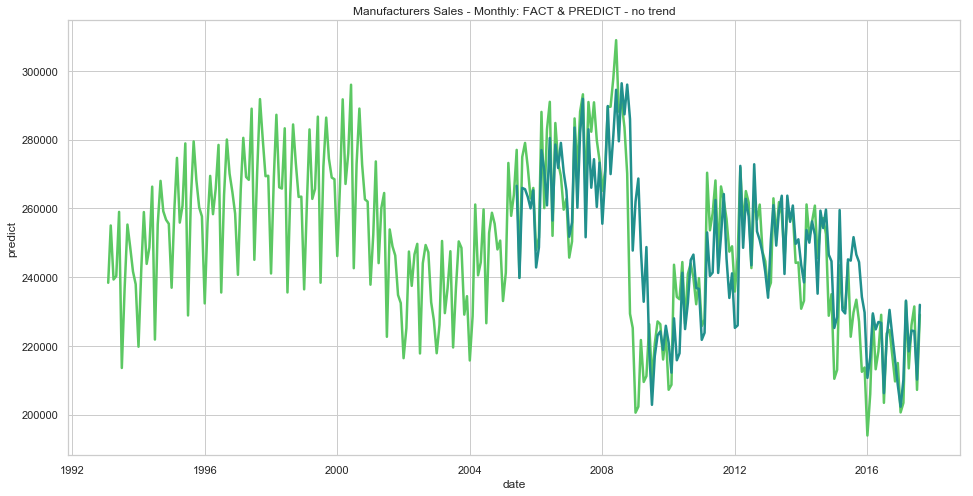

In [30]:
metric = smape(df_with_preds['value_no_trend'][148:], df_with_preds['predict'][148:])
print('SMAPE =', metric.round(1), '%')
plot_ts('value_no_trend', df_with_preds, 'date', '')
plot_ts('predict', df_with_preds, 'date', 'Manufacturers Sales - Monthly: FACT & PREDICT - no trend')
plt.show()

SMAPE = 3.8 %


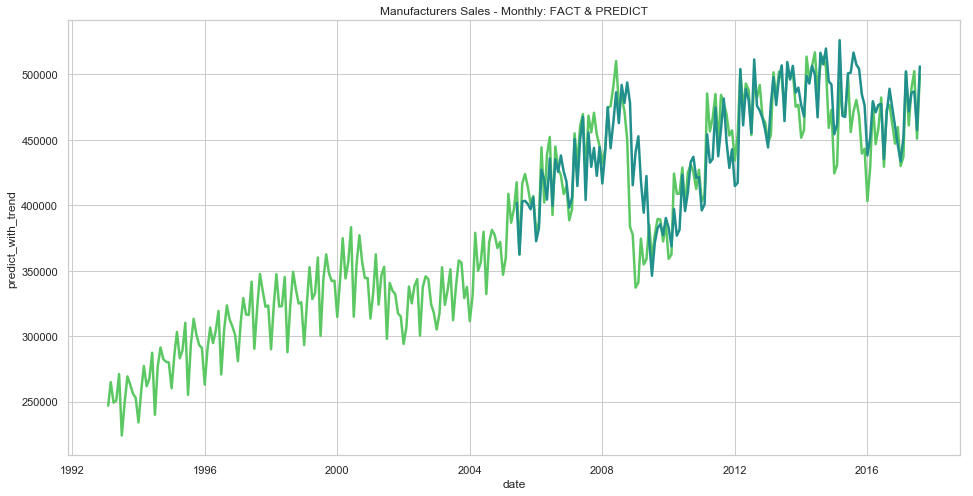

In [31]:
df_with_preds['predict_with_trend'] = df_with_preds['predict'].copy()
for i in range(0, len(df_with_preds)):
    df_with_preds['predict_with_trend'].iloc[i] = df_with_preds['predict'].iloc[i] * ((df_mfg_sales['year_to_year'][:12*12].mean() ** (1/12)) ** (i + 14))
metric = smape(df_with_preds['value'][148:], df_with_preds['predict_with_trend'][148:])
print('SMAPE =', metric.round(1), '%')
plot_ts('value', df_with_preds, 'date', '')
plot_ts('predict_with_trend', df_with_preds, 'date', 'Manufacturers Sales - Monthly: FACT & PREDICT')
plt.show()

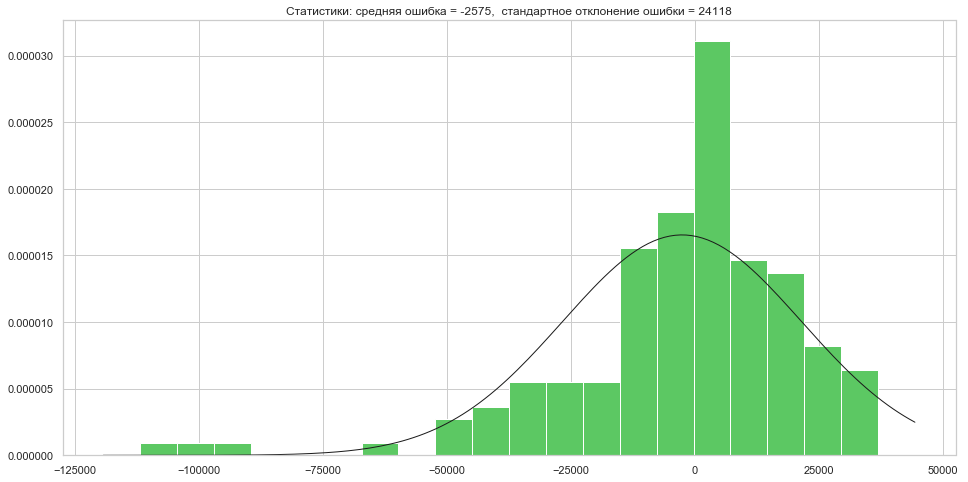

In [32]:
m_e = (df_with_preds['value'][148:] - df_with_preds['predict_with_trend'][148:]).mean()
std_e = (df_with_preds['value'][148:] - df_with_preds['predict_with_trend'][148:]).std()
plt.hist(df_with_preds['value'][148:] -
         df_with_preds['predict_with_trend'][148:], density=True, bins=20)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 150)
p = norm.pdf(x, m_e, std_e)
plt.plot(x, p, 'k', linewidth=1)
plt.title("Статистики: средняя ошибка = %.0f,  стандартное отклонение ошибки = %.0f" % (m_e, std_e))

plt.show()

Видим, что средняя ошибка отрицательная (то есть на завышение прогноза), однако значение составляет меньше, чем 0.6% от среднего. 
Если наложить форму плотности нормального распределения, с тем же средним и стандартным отклонением, то заметно, что распределение ошибки в целом, похоже на нормальное, однако, во первый есть несколько больших выбросов (кризис 2008-2009), где значение прогноза завышено по отношению к факту. А вот в правом хвосте наблюдений, наоборот, нет.

Посмотрим также на вклады факторов в прогноз:

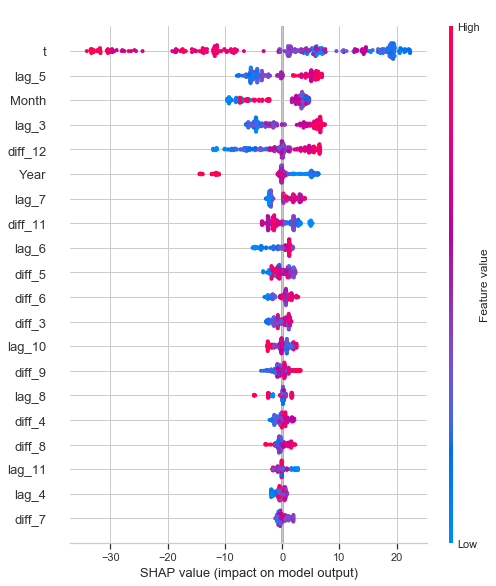

In [33]:
gbm.fit(df_mfg_sales[13:][lst_f], df_mfg_sales[13:]['value_no_trend'])
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(df_mfg_sales[13:][lst_f])
shap_gr = shap.summary_plot(shap_values, df_mfg_sales[13:][lst_f])
plt.show()

Видим, что зависимости достаточно монотонны, по крайней мере, по первым показателям. Наибольший вклад в прогноз у показателя t (трендовый показатель), при этом зависимость выглядит почти монотонно отрицательной, что логично, так как был сдвиг в ряде вниз и замедление тренда.
Вторым по вкладу стал лаг - 5 месяца, четвертым после сезонности - лаг 3 месяцев назад. Следующий по размеру вклада - прирост месяц к месяцу 12 месяцев назад. Зависимость от этих трех показателей выглядят как монотоноо положительные.

<b> Итого: была построена модель lightgbm для ряда общих продаж, предварительно очищенного от тренда, подсчитанного из приростов год к году. В качестве признака использовались лаги и лагированные приросты месяц к месяцу, а также различные показатели от даты. Точность на очищенном ряду на кросс-валидации составила 3.8% (SMAPE), что как мне кажется, неплохо с учетом того, что валидировалось также на сдвиге (кризисе). На финальном ряде с учетом добавления тренда также получилась точность 3.8% (SMAPE). Ошибка прогноза, если не принимать во внимание выбросы, в целом похожа на нормальное значение, систематического занижения или завышения нет. </b>